In [1]:
%pylab inline
import re
import pandas as pd
import numpy as np
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


In [4]:
def loadSORTCERY(file_Dir,uniqueName):
    probabilities = np.array([re.split("\s+",each.strip()) for each in 
                                  open(file_Dir+"norm_distributions_cutoff_100","r").readlines()]).astype(float)
    seqForProbs = open(file_Dir+"sequences_cutoff_100",'r').readlines()
    seqForProbs = [seqForProbs[each].strip().split() for each in range(0,len(seqForProbs))] #Get only the background and seq
    
    #ranking = [each.strip().split() for each in open("/home/vxue/luther/SORTCERY/SORTCERY2_all/ranking_cutoff_100").readlines()]
    #ranking = [int(each[0]) for each in sorted(ranking,key=lambda x: int(x[1]))]
    
    foo = pd.DataFrame({'bg':[str(each[0]) for each in seqForProbs],'seq':[each[1] for each in seqForProbs]})
    foo.loc[foo.bg==str(0),'bg']='P'
    foo.loc[foo.bg==str(1),'bg']='B'
    
    #foo['rank_2_all']=ranking
    for each in range(12):
        foo[uniqueName+'_p'+str(each)]=(probabilities[:,each])
    
    sequencesByRank = foo    
        
    expectedValue = []
    for index,each in sequencesByRank.iterrows():
        probs = each[[uniqueName+'_p'+str(gate) for gate in range(12)]].values
        expectedValue.append(np.dot(probs,np.array(range(12,0,-1))))
    sequencesByRank[uniqueName+'_expectedValue'] = expectedValue
    
    
    copyNum0 = pd.read_csv(file_Dir+'cell_counts_dnaframe_0',header=None,delimiter=' ',
                           usecols=range(12),names=[uniqueName+'_CN_'+str(each) for each in range(12)])
    copyNum1 = pd.read_csv(file_Dir+'cell_counts_dnaframe_1',header=None,delimiter=' ',
                           usecols=range(12),names=[uniqueName+'_CN_'+str(each) for each in range(12)])
    
    #uniqueSeqs0 = pd.read_csv('/home/vxue/luther/SORTCERY/SORTCERY2_Strict_a/unique_seqs_seqframe_0',header=None,delimiter=' ',names=['seq'])
    uniqueSeqs0=[each.strip() for each in open(file_Dir+'unique_seqs_dnaframe_0','r').readlines()]
    uniqueSeqs1=[each.strip() for each in open(file_Dir+'unique_seqs_dnaframe_1','r').readlines()]
    
    copyNum0['seq']=uniqueSeqs0
    copyNum1['seq']=uniqueSeqs1
    copyNum0['bg']='P'
    copyNum1['bg']='B'
    combined = copyNum0.append(copyNum1,ignore_index=True)
    combined[uniqueName+'_CN_tot']=combined[[uniqueName+'_CN_'+str(each) for each in range(12)]].sum(axis=1)
    
    
    
    sequencesByRank =  pd.merge(sequencesByRank,combined,on=['seq','bg'])

    return sequencesByRank

#SORTCERY_Cleanup_multiplex_00-Contam_analysis

def normalizeToRate(observedCounts,totalPerGate,rate):
    probs = observedCounts/totalPerGate.astype(float)
    normCounts = probs*rate
    distOverGates = normCounts/sum(normCounts)
    return distOverGates

def reverseClusterWStd(lookupTableFile,beforeMergedDataframe,uniqueName,myRates,totalPerGate):

    lookupTable = pd.read_csv(lookupTableFile,delimiter='\t',header=None,names=('read','type','percent','percent_chimera','parent'))
    print("out.up",len(lookupTable))
    #append a UID
    uid=[]
    for index,each in lookupTable.iterrows():
        uid.append(int(each.read[0:each.read.index(';')]))
    lookupTable['uid']=uid
    
    #match up UID to original file (prior to clustering)
    fullSeqs = pd.read_csv(seqCounts,header=None,delimiter='\s+',names=('count','seq'))
    fullSeqs['uid']=range(len(fullSeqs))
    print("diversity.txt",len(fullSeqs))
    
    #merge lookup table with full seqs on UID
    lookupTable = pd.merge(lookupTable,fullSeqs,on='uid')
    print("Merge out.up and diversity.txt:",len(lookupTable))
    
    #Set the parent of otus to themselves | This file has chimeras
    lookupTable.ix[lookupTable["type"]=='otu','parent']=lookupTable[lookupTable["type"]=='otu']['uid'].astype(str)
    
    
    #Merge the lookup table with the distribution information
    myMerged = pd.merge(lookupTable,beforeMergedDataframe,on='seq')
    print("Merge DNA SORTCERY frame and cluster table (w/Chimeras):",len(myMerged))
    myMerged = myMerged[(myMerged['type']=='otu') | (myMerged['type']=='match')]
    myMerged['parent']=myMerged['parent'].astype('int')
    print("Merge DNA SORTCERY frame and cluster table (w/o Chimeras):",len(myMerged))
    
    #For each of the clusters, split off a child if it doesn't have the same distribution as the parent
    grouped = myMerged.groupby('parent')
    for parent,each in grouped:
        assert len(each.ix[each["type"]=='otu','seq'].values)==1
        
        parentCNCount = each[each["type"]=='otu'][[uniqueName+"_CN_"+str(i) for i in range(12)]]
        parentSeq = each.ix[each["type"]=='otu','seq'].values[0]
        parentUid = each.ix[each["type"]=='otu','uid'].values[0]
        parentProtein = each.ix[each["type"]=='otu','protein'].values[0]
        
        
        for index,clone in each[each["type"]=='match'].iterrows():
            
            childCNCount = clone[[uniqueName+"_CN_"+str(i) for i in range(12)]]
            childUID = clone['uid']
            childSeq = clone['seq']
            childProtein = clone['protein']

            
            #Take the observed counts of reads and normalize it to 
            observedCounts = np.array(childCNCount)
            normalizedObserved = normalizeToRate(observedCounts+1,totalPerGate,myRates)*sum(observedCounts)

            #expectedCounts = ((np.array(parentCNCount)/sum(np.array(parentCNCount)).astype(float))*sum(np.array(childCNCount))).ravel()
            #expectedCounts= expectedCounts+1 # Pseudo count
            normalizedExpected = normalizeToRate(np.array(parentCNCount)[0]+1,totalPerGate,myRates)*sum(observedCounts)

            
            #The smaller the alpha level, the more confident you are that the distributions are different.
            #That means that you are less likely to split the cluster
            # Closer to zero => less clusters
            pValue = scipy.stats.chisquare(normalizedObserved,f_exp=normalizedExpected)[1]
            myMerged.ix[myMerged['uid']==childUID,'pValue'] = pValue
            
            alphaLevel = 0.005/len(clone)
            
            if(pValue<alphaLevel): #<10**-150
                #print "-",childUID
                #Undo cluster
                myMerged.ix[myMerged['uid']==childUID,'new_parent']=childUID
                myMerged.ix[myMerged['uid']==childUID,'new_protein']=childProtein
                myMerged.ix[myMerged['uid']==childUID,'new_seq']=childSeq
            else:
                
                myMerged.ix[myMerged['uid']==childUID,'new_parent']=parentUid
                myMerged.ix[myMerged['uid']==childUID,'new_protein']=parentProtein
                myMerged.ix[myMerged['uid']==childUID,'new_seq']=parentSeq
                #print "+",childUID,parentUid
     
    print("Final Size after uncluster similar seq, different profile:",len(myMerged))
    return myMerged

In [5]:
baseName = "/home/vxue/data/SORTCERY_PUBLICATION/bfl1/workspace/bfl1_sortcery_contam_dna/"

lookupTableFile = baseName+"out.up"
seqCounts = baseName+"diversity.txt"
uniqueName = "bfl1"
beforeMergedDataframe = loadSORTCERY(baseName,uniqueName)
totalPerGate = np.array(beforeMergedDataframe[[uniqueName+"_CN_"+str(i) for i in range(12)]].sum(axis=0))
myRates = [3526,5976,7412,7001,6855,7599,7445,8578,8525,7331,4759,1277]

In [4]:
print(len(beforeMergedDataframe))
print(len(beforeMergedDataframe.seq.unique()))
print(len(beforeMergedDataframe[beforeMergedDataframe.seq.str.contains("N")]))
print(beforeMergedDataframe[uniqueName+"_CN_tot"].sum())
#Assert that the dna sequences can be mapped uniquely to a bg
beforeMergedDataframe = beforeMergedDataframe.groupby('seq').filter(lambda x: len(x)==1)
print(len(beforeMergedDataframe))
print(len(beforeMergedDataframe.seq.unique()))
print(beforeMergedDataframe[uniqueName+"_CN_tot"].sum())


7875
7875
40
61611539
7875
7875
61611539


In [7]:
# Append the Protein sequence to the array

from Bio.Seq import Seq
from Bio.Alphabet import generic_dna

proteinSeqs = []
for index,each in beforeMergedDataframe.iterrows():
    my_seq = Seq(each['seq'],generic_dna).translate()
    proteinSeqs.append(str(my_seq))
beforeMergedDataframe['protein']=proteinSeqs

In [8]:
updatedCluster = reverseClusterWStd(lookupTableFile,beforeMergedDataframe,uniqueName,myRates,totalPerGate)
updatedCluster.ix[updatedCluster.new_parent.isnull(),'new_parent']=updatedCluster[updatedCluster.new_parent.isnull()]['parent']
updatedCluster.ix[updatedCluster.new_seq.isnull(),'new_seq']=updatedCluster[updatedCluster.new_seq.isnull()]['seq']
updatedCluster.ix[updatedCluster.new_protein.isnull(),'new_protein']=updatedCluster[updatedCluster.new_protein.isnull()]['protein']

out.up 27320
diversity.txt 27320
Merge out.up and diversity.txt: 27320


/home/vxue/anaconda/envs/localEnv2/lib/python3.5/site-packages/ipykernel/__main__.py:77: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/vxue/anaconda/envs/localEnv2/lib/python3.5/site-packages/ipykernel/__main__.py:90: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Merge DNA SORTCERY frame and cluster table (w/Chimeras): 7835
Merge DNA SORTCERY frame and cluster table (w/o Chimeras): 7545


/home/vxue/anaconda/envs/localEnv2/lib/python3.5/site-packages/ipykernel/__main__.py:119: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Final Size after uncluster similar seq, different profile: 7545


In [9]:
for index, each in updatedCluster.groupby("new_protein"):
    # Sometimes when combining clusters on protein sequence, there may be multiple OTUs.
    # For each cluster, find the one with the most counts and set that as the new parent.
    updatedCluster.ix[updatedCluster.uid.isin(each.uid),'new_new_parent']=each.sort_values(by=uniqueName+'_CN_tot',ascending=False)[0:1]['uid'].values[0]

In [10]:
print("Before Cluster",len(updatedCluster)) #Before clustering
print("After Cluster" ,len(updatedCluster.groupby('parent').sum())) #After clustering
print("After clustering + unclustering",len(updatedCluster.groupby('new_parent').sum())) #After clustering + unclustering
print
print("After clustering + unclustering + Reclustering DNA",len(updatedCluster.groupby('new_new_parent').sum())) #After clustering + unclustering + Reclustering
print("After clustering + unclustering + Reclustering PROT", len(updatedCluster.groupby('new_protein').sum())) #After clustering + unclustering + Reclustering

Before Cluster 7545
After Cluster 6513
After clustering + unclustering 7229
After clustering + unclustering + Reclustering DNA 7040
After clustering + unclustering + Reclustering PROT 7040


In [11]:
x_b = "GGCCGTCCG[ACG][AT][CG]ATTTGG[ACGT][AT]TGCGCAGGAACTG[AG][CGT]ACGT[ACGT][ACGT]CG[CG]CGATGAATTT[ACG][ACT]C[AG][AC]ATAT[ACGT][ACG]C"
m_b = "GGCCGT[ACGT][CG]GGAA[CGT][ACGT]C[CG]A[AT][AG][CT]C[AG][CGT]TCAGGAACTG[AG][ACGT]ACGTATTGGCGATGAA[ACGT][ACT]T[ACG]A[GT]GCGTATTAT"
f_b = "GGCCGTCCG[ACG][ACT]AATTTGGATT[GT][ACG]TCAG[ACGT][AGT]CCTGCGTCGT[ACGT][CGT]CGGCGAT[ACG][AT][GT][ACGT][ACT]TAATGCGTAT[ACGT][CT]T"
x_p = "GGCCAATGG[ACG][AT][CG]CGTGAA[ACGT][AT]TGGCGCCCAACTG[AG][CGT]ACGC[ACGT][ACGT]CG[CG]CGATGATCTG[ACG][ACT]C[AG][AC]ACAA[ACGT][ACG]C"
m_p = "GGCCAA[ACGT][CG]GGCG[CGT][ACGT]C[CG]A[AT][AG][CT]C[AG][CGT]TGCCCAACTG[AG][ACGT]ACGCATGGCGGATGAT[ACGT][ACT]T[ACG]A[GT]GCCCAATAT"
f_p = "GGCCAATGG[ACG][ACT]ACGTGAAATT[GT][ACG]TGCC[ACGT][AGT]CCTGCGTCGC[ACGT][CGT]CGCGGAT[ACG][AT][GT][ACGT][ACT]TAATGCCCAA[ACGT][CT]T"
justinRegex =[x_b,m_b,f_b,x_p,m_p,f_p]

def getLibrary(inputSeq):
    label = ['x_b','m_b','f_b','x_p','m_p','f_p']
    
    matches = []
    
    for label,regx in zip(label,justinRegex):
        if(re.match(regx,inputSeq)):
            matches.append(label)
    
    if(len(matches)==0):
        return "unknown"
    return ",".join(matches)

updatedCluster['source'] = updatedCluster.apply(lambda x: getLibrary(x.new_seq),axis=1)

In [12]:
updatedCluster.to_pickle("/home/vxue/data/SORTCERY_PUBLICATION/bfl1/workspace/processed/bfl1_data_usearch.pickle")

# Save it Out

In [13]:
#SORTCERY_ALL_CLEAN
def getProbs(updatedCluster, uniqueName, myRates):
    
    myExtractArray = [uniqueName+'_CN_'+str(i) for i in range(12)]
    
    copyNums = updatedCluster.groupby(('bg','new_protein')).sum()[myExtractArray].reset_index()
    
    # Get a count of the number of cells that fall in each gate (after normalizing for gate)
    # PROB READ IN GATE * SCALING FACTOR
    probs = myRates*(copyNums[[uniqueName+'_CN_'+str(i) for i in range(12)]] / copyNums.sum(axis=0)[[uniqueName+'_CN_'+str(i) for i in range(12)]])
    
    #normalize each one of observed cells per gate to the total number of cells observed for that clone
    probs = probs.apply(lambda x: x[[uniqueName+'_CN_'+str(i) for i in range(12)]]/ x[[uniqueName+'_CN_'+str(i) for i in range(12)]].sum(), axis=1)
    
    probs.columns = [uniqueName+'_p'+str(i) for i in range(12)]
    
    
    
    probs[[uniqueName+'_CN_'+str(i) for i in range(12)]]=copyNums[[uniqueName+'_CN_'+str(i) for i in range(12)]]
    probs[uniqueName+'_CN_tot'] = copyNums[[uniqueName+'_CN_'+str(i) for i in range(12)]].sum(axis=1)
    probs['seq'] = copyNums['new_protein']
    probs['bg'] = copyNums['bg']
    probs[uniqueName+'_expectedValue'] = probs.apply(lambda x: np.dot(np.array(x[[uniqueName+'_p'+str(gate) for gate in range(12)]]),np.array(range(12,0,-1))),axis=1)

    
    

    return probs
    

In [14]:
bfl1Sort = getProbs(updatedCluster,'bfl1',myRates)

In [16]:
bfl1Sort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7040 entries, 0 to 7039
Data columns (total 28 columns):
bfl1_p0               7040 non-null float64
bfl1_p1               7040 non-null float64
bfl1_p2               7040 non-null float64
bfl1_p3               7040 non-null float64
bfl1_p4               7040 non-null float64
bfl1_p5               7040 non-null float64
bfl1_p6               7040 non-null float64
bfl1_p7               7040 non-null float64
bfl1_p8               7040 non-null float64
bfl1_p9               7040 non-null float64
bfl1_p10              7040 non-null float64
bfl1_p11              7040 non-null float64
bfl1_CN_0             7040 non-null int64
bfl1_CN_1             7040 non-null int64
bfl1_CN_2             7040 non-null int64
bfl1_CN_3             7040 non-null int64
bfl1_CN_4             7040 non-null int64
bfl1_CN_5             7040 non-null int64
bfl1_CN_6             7040 non-null int64
bfl1_CN_7             7040 non-null int64
bfl1_CN_8             7040 no

In [17]:
bfl1Sort.to_pickle("/home/vxue/data/SORTCERY_PUBLICATION/bfl1/workspace/processed/bfl1_sort.pickle")

# Some Composition Analysis

In [18]:
x_b = "GGCCGTCCG[ACG][AT][CG]ATTTGG[ACGT][AT]TGCGCAGGAACTG[AG][CGT]ACGT[ACGT][ACGT]CG[CG]CGATGAATTT[ACG][ACT]C[AG][AC]ATAT[ACGT][ACG]C"
m_b = "GGCCGT[ACGT][CG]GGAA[CGT][ACGT]C[CG]A[AT][AG][CT]C[AG][CGT]TCAGGAACTG[AG][ACGT]ACGTATTGGCGATGAA[ACGT][ACT]T[ACG]A[GT]GCGTATTAT"
f_b = "GGCCGTCCG[ACG][ACT]AATTTGGATT[GT][ACG]TCAG[ACGT][AGT]CCTGCGTCGT[ACGT][CGT]CGGCGAT[ACG][AT][GT][ACGT][ACT]TAATGCGTAT[ACGT][CT]T"
x_p = "GGCCAATGG[ACG][AT][CG]CGTGAA[ACGT][AT]TGGCGCCCAACTG[AG][CGT]ACGC[ACGT][ACGT]CG[CG]CGATGATCTG[ACG][ACT]C[AG][AC]ACAA[ACGT][ACG]C"
m_p = "GGCCAA[ACGT][CG]GGCG[CGT][ACGT]C[CG]A[AT][AG][CT]C[AG][CGT]TGCCCAACTG[AG][ACGT]ACGCATGGCGGATGAT[ACGT][ACT]T[ACG]A[GT]GCCCAATAT"
f_p = "GGCCAATGG[ACG][ACT]ACGTGAAATT[GT][ACG]TGCC[ACGT][AGT]CCTGCGTCGC[ACGT][CGT]CGCGGAT[ACG][AT][GT][ACGT][ACT]TAATGCCCAA[ACGT][CT]T"
justinRegex =[x_b,m_b,f_b,x_p,m_p,f_p]

In [20]:
allCounts = []

for each in justinRegex:
    myCount = updatedCluster[updatedCluster.new_seq.str.contains(each)]['count'].sum()
    print(myCount)
    allCounts.append(myCount)

2254611
7108236
5400225
574832
2071064
3029842


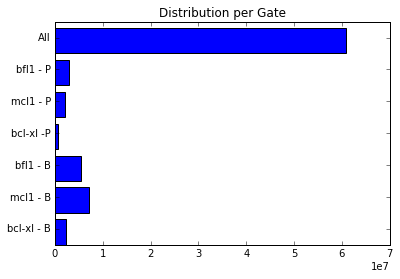

In [21]:
readCoverage = list(allCounts)
readCoverage.append(updatedCluster['count'].sum())
barh(range(7), readCoverage)
yticks(arange(7)+0.5,['bcl-xl - B','mcl1 - B','bfl1 - B','bcl-xl -P','mcl1 - P','bfl1 - P','All'])
title("Distribution per Gate")

In [23]:
allCounts

[2254611, 7108236, 5400225, 574832, 2071064, 3029842]

In [24]:
updatedCluster[updatedCluster.new_seq.str.contains('GGCCAATGGGCGCGTGAAATTGGCGCCCAACTGCGTCGCATGGCGGATGATCTGAATGCCCAATAT')]['count']

7565    114
Name: count, dtype: int64

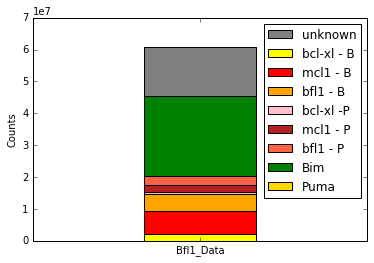

In [25]:
myBottom = 0
fig,ax = plt.subplots()

ax.bar(1,updatedCluster['count'].sum(),0.5,color='grey',label='unknown')

myColors=['yellow','red','orange','pink','firebrick','tomato','springgreen','gold']
myLabels = ['bcl-xl - B','mcl1 - B','bfl1 - B','bcl-xl -P','mcl1 - P','bfl1 - P','All']
for idx,each in enumerate(allCounts):
    ax.bar(1,each,0.5,bottom=myBottom,color=myColors[idx],label=myLabels[idx])
    myBottom+=each


    
bimCount = sum(updatedCluster[updatedCluster.new_seq.str.contains('GGCCGTCCGGAAATTTGGATTGCGCAGGAACTGCGTCGTATTGGCGATGAATTTAATGCGTATTAT')]['count'])
ax.bar(1,bimCount,0.5,bottom=myBottom,color='green',label='Bim')
myBottom+=bimCount

pumaCount = sum(updatedCluster[updatedCluster.new_seq.str.contains('GGCCAATGGGCGCGTGAAATTGGCGCCCAACTGCGTCGCATGGCGGATGATCTGAATGCCCAATAT')]['count'])
ax.bar(1,pumaCount,0.5,bottom=myBottom,color='gold',label='Puma')
myBottom+=pumaCount


    
ax.set_xticks([1.25])
ax.set_xticklabels(['Bfl1_Data'])
ax.set_ylabel("Counts")
ax.set_xlim(0.5 ,2)
legend()

In [26]:
sum(allCounts) # 20 million reads were as designed

20438810

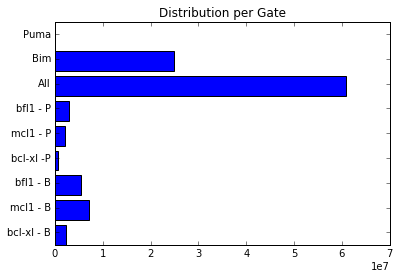

In [27]:
readCoverage = list(allCounts)
readCoverage.append(updatedCluster['count'].sum())
readCoverage.append(bimCount)
readCoverage.append(pumaCount)
barh(range(9), readCoverage)
yticks(arange(9)+0.5,['bcl-xl - B','mcl1 - B','bfl1 - B','bcl-xl -P','mcl1 - P','bfl1 - P','All','Bim','Puma'])
title("Distribution per Gate")

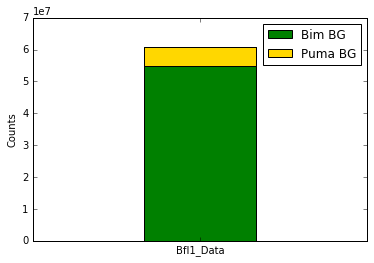

In [28]:
myBottom = 0
fig,ax = plt.subplots()

ax.bar(1,updatedCluster['count'].sum(),0.5,color='grey')

myColors=['yellow','red','orange','pink','firebrick','tomato','springgreen','gold']

    
bimCount = sum(updatedCluster[updatedCluster.bg=='B']['count'])
ax.bar(1,bimCount,0.5,bottom=myBottom,color='green',label='Bim BG')
myBottom+=bimCount

pumaCount = sum(updatedCluster[updatedCluster.bg=='P']['count'])
ax.bar(1,pumaCount,0.5,bottom=myBottom,color='gold',label='Puma BG')
myBottom+=pumaCount


    
ax.set_xticks([1.25])
ax.set_xticklabels(['Bfl1_Data'])
ax.set_ylabel("Counts")
ax.set_xlim(0.5 ,2)
legend(loc=0)

In [29]:
pumaCount

6132895

In [30]:
updatedCluster[updatedCluster.bg=='P'].ix[68].seq

/home/vxue/anaconda/envs/localEnv2/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


'GAACAATGGGCGCGTGAAATTGGCGCCCAAATTCGTCGCATTGCGGATGATTTTAATGCCCAATAT'

In [31]:
# %load PyScripts/makeLogoFromList.py
#SVM_Ranking_29
from weblogolib import *
from IPython.display import Image


def makeLogoFromList(sequences):
    myFile = open("/tmp/seqlogo",'w')
    count = 0
    for each in sequences:
        if("*" not in each and "X" not in each):
            myFile.write(each+"\n")
            #myFile.write("\n")
        count+=1
        #if (count>10000):
        #    break
    myFile.close()
    
    myFile=open("/tmp/seqlogo",'r')
    seqs = read_seq_data(myFile)
    data = LogoData.from_seqs(seqs)
    options = LogoOptions()
    options.fineprint=""
    options.resolution=300
    options.fontsize=8
    options.unit_name="probability"
    myFormat = LogoFormat(data, options)
    return png_formatter(data,myFormat)

temp = makeLogoFromList(['AATCGA'])
myFile=open("/tmp/seqlogo",'r')
seqs = read_seq_data(myFile)   
data = LogoData.from_seqs(seqs)


In [32]:
justinRegexJoined = "|".join(justinRegex)

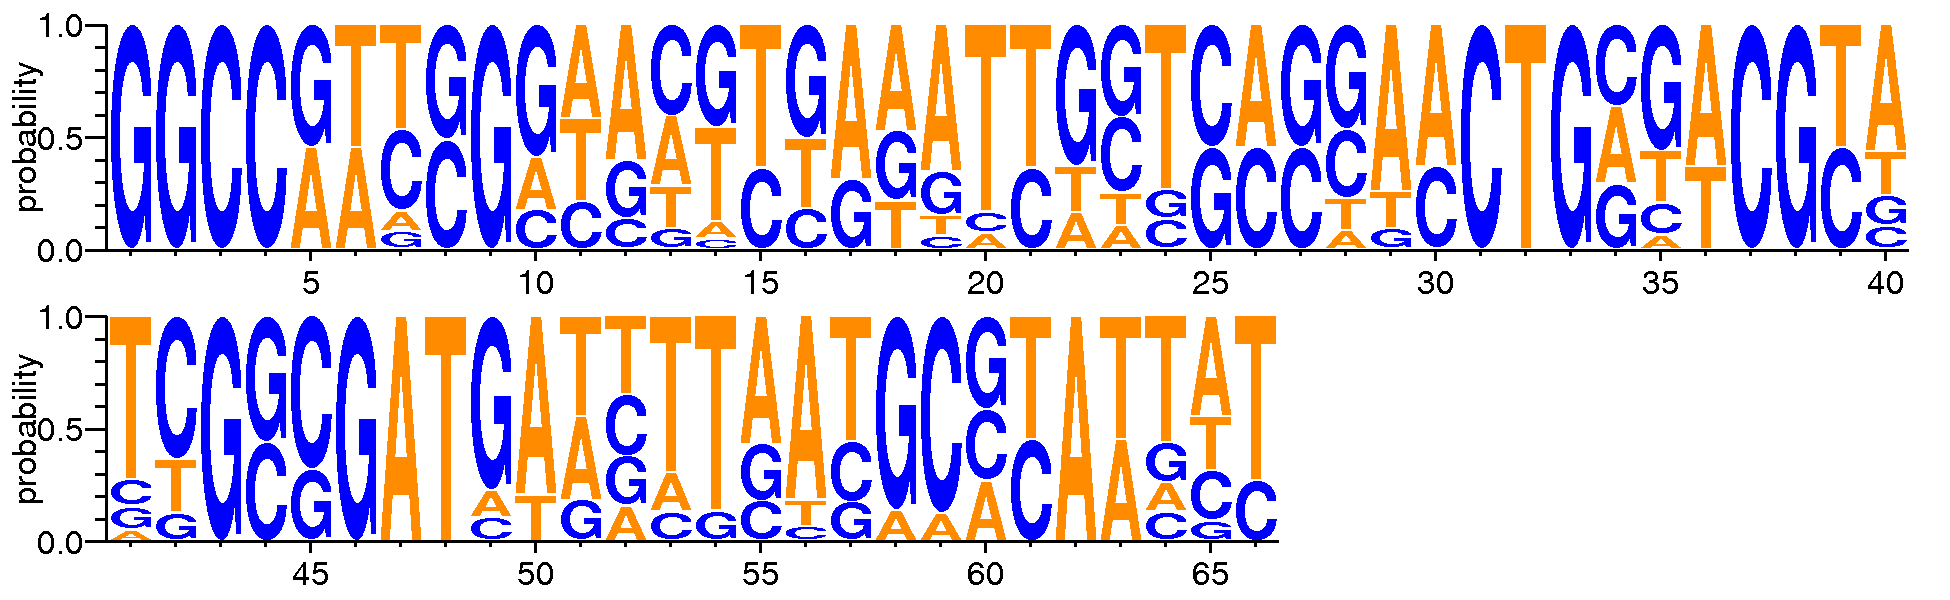

In [33]:
Image(makeLogoFromList(updatedCluster[updatedCluster.new_seq.str.contains(justinRegexJoined)].new_seq))

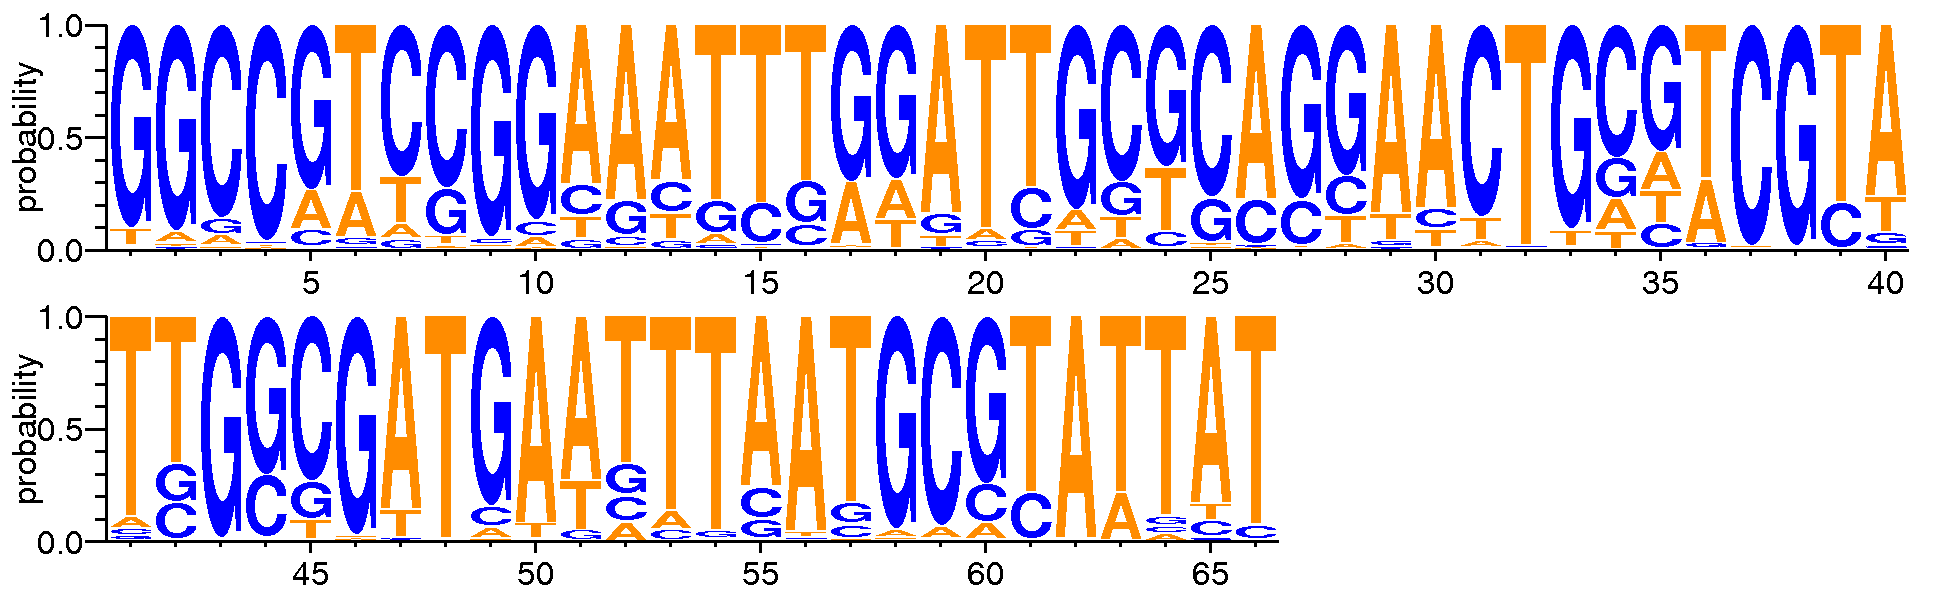

In [34]:
Image(makeLogoFromList(updatedCluster[~updatedCluster.new_seq.str.contains(justinRegexJoined)].new_seq))

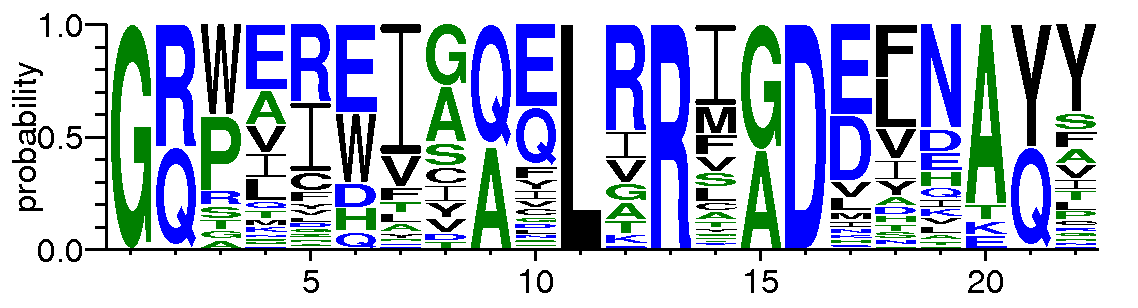

In [35]:
Image(makeLogoFromList(updatedCluster[updatedCluster.new_seq.str.contains(justinRegexJoined)].new_protein))

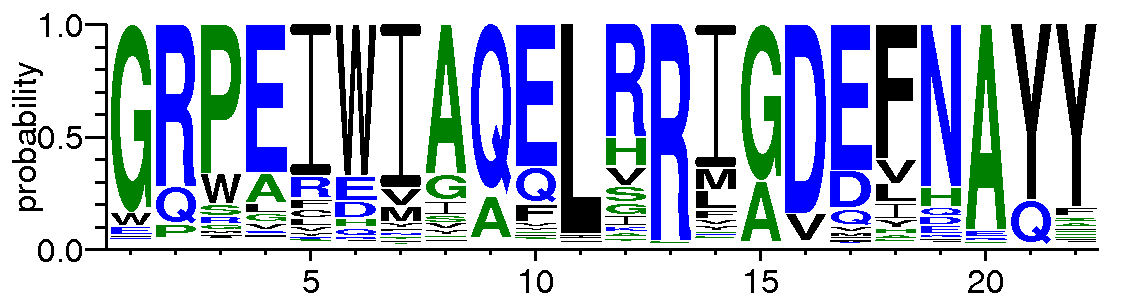

In [36]:
Image(makeLogoFromList(updatedCluster[~updatedCluster.new_seq.str.contains(justinRegexJoined)].new_protein))

In [37]:
grouped = updatedCluster.groupby("new_seq")

87
34
11
9
9
6
5
5
4
4


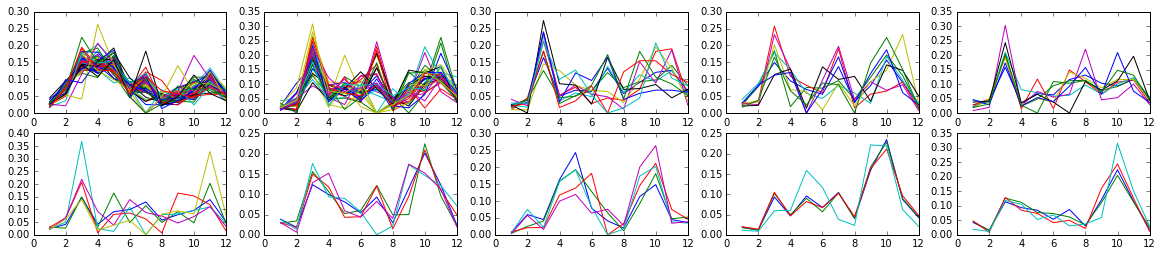

In [39]:
numToVisuzalize = 0

fig,ax = plt.subplots(2,5,figsize=(20,4))

for i in sorted(grouped,key=lambda x: len(x[1]),reverse=True):
    
    print(len(i[1]))    
    
    for idx,row in i[1].iterrows():
        foo = row[['bfl1_p'+str(j) for j in range(12)]].squeeze()
        ax[numToVisuzalize//5][numToVisuzalize%5].plot(range(12,0,-1), foo)
    
    numToVisuzalize+=1
    
    if(numToVisuzalize==10):
        break

In [40]:
updatedCluster[~updatedCluster.new_seq.str.contains(justinRegexJoined)][['new_protein','count']]

,new_protein,count
0,GRPEIWIAQELRRIGDEFNAYY,24695096
1,GRPEIWIAQELHRIGDEFNAYY,6618071
2,GRPEIWIAQELRRIGVEFNAYY,5715705
3,GRPEIWMAQFLSRLADQFNAYY,847080
16,GQWADHIIAQLKRMADDINAQY,59692
18,GRPEIWVAQELKRIGDEFNAYY,57462
20,GRPEIWIAQELRRIGEEFNAYY,56744
33,GRPEIWLAQLLGRFADEFNAYY,43093
39,GRPEIWIAQELRRIGDEFNAYY,40097
44,GRPIIWICQDLRSVGDDLNAYF,38601
